In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.metrics import balanced_accuracy_score as bas

import gc
gc.enable()

In [9]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential, Input
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


<hr>

In [2]:
# data = pd.read_csv('../data-simplified-1-reduced-wordbal-800.csv')
data = pd.read_csv('../data-reduced-800-v2-shuffled.csv', index_col = 0)

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
test = pd.read_csv('../test.csv')

In [4]:
catcode = pd.read_csv('../data-simplified-1-catcode.csv', header = None, names = ['category'])['category']

In [5]:
catcode.to_dict()

{0: '3D_GLASSES',
 1: '3D_PENS',
 2: '3D_PRINTERS',
 3: '3D_PRINTER_FILAMENTS',
 4: 'ABDOMINAL_TONING_BELTS',
 5: 'ABS_SENSORS',
 6: 'AB_ROLLER_WHEELS',
 7: 'ACCORDIONS',
 8: 'ACOUSTIC_GUITARS',
 9: 'ACOUSTIC_PANELS',
 10: 'ACTION_CAMERA_MOUNTS',
 11: 'ACTION_FIGURES',
 12: 'ADHESIVE_TAPES',
 13: 'AEROBIC_CRUNCH_MACHINES',
 14: 'AFTERSHAVES',
 15: 'AGOGOS',
 16: 'AIRBAGS',
 17: 'AIRBAG_MODULES',
 18: 'AIRBRUSHES',
 19: 'AIRGUN_PELLETS',
 20: 'AIRSOFT_GUNS',
 21: 'AIR_COMPRESSORS',
 22: 'AIR_CONDITIONERS',
 23: 'AIR_CONDITIONER_REMOTE_CONTROLS',
 24: 'AIR_FRESHENERS',
 25: 'AIR_MATTRESSES',
 26: 'ALARMS_AND_SENSORS',
 27: 'ALARM_CLOCKS',
 28: 'ALL_IN_ONE',
 29: 'ALTERNATORS',
 30: 'ALTERNATOR_PULLEYS',
 31: 'AM_FM_RADIOS',
 32: 'ANALOG_CAMERAS',
 33: 'ANGLE_CLAMPS',
 34: 'ANIMAL_AND_BALL_HOPPERS',
 35: 'ANIMAL_CLIPPERS',
 36: 'ANTIQUE_CHAIRS',
 37: 'ANTIQUE_TAPE_RECORDERS',
 38: 'ANTIQUE_TOY_CARS',
 39: 'ANTIVIRUS_AND_INTERNET_SECURITY',
 40: 'ANTI_STATIC_PLIERS',
 41: 'ANTI_THEFT_STUDS

In [11]:
data.head()

,title,label_quality,language,category,priorities
14106282,Engranaje Bomba Inyectora Dbr Peugeot 205 306...,1,0,807,51
6991524,Luva Térmica Mão De Gato 53cm Therm Soft,1,1,1239,0
19616569,Chave Biela Starfer C/furo 17,0,1,1581,61
12046658,Bap N&ordm;3 1200 Mm C Parafuso Nz Com 10 Unid...,1,1,1064,4
15112239,Soporte Arkon Cargador Auto P/ Celular Galaxy ...,1,0,65,1


<hr>

In [12]:
def normalize(curr):
    # remove accent
    curr = curr.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    # to lower case
    curr = curr.str.lower()
    # remove not alphanumerics or . ,
    curr = curr.str.replace('[^a-zA-Z0-9.,]', ' ')
    
    # let , and . be the same char
    curr = curr.str.replace('[.]', ',')
    
    # remove . , not between numbers
    curr = curr.str.replace('(?<=[0-9])[,]+(?=[0-9])', '.')
    curr = curr.str.replace('[,]', ' ')
    
    # set all digits to 0
    curr = curr.str.replace('[0-9]', '0')
    
    # separate ' <digits><letters ' like in 22g or 12ms
    # curr = curr.str.replace('(^| )([0-9]+)([a-zA-Z]+)($| )', r'\1\2 \3\4')
    
    # remove some Pt plurals
    curr = curr.str.replace('([a-zA-Z]+[aeiou])(s)', r'\1')
    
    # Other ideas: 
    
    return curr

In [13]:
sp = int(len(data) * 0.8) # Split Point

In [14]:
full = pd.concat([data[['title']], test[['title']]])

In [15]:
X_full = full.title

In [17]:
%%time
# # for char processed
X_full = normalize(X_full)

CPU times: user 19.8 s, sys: 380 ms, total: 20.2 s
Wall time: 20.2 s


In [18]:
%%time
X_full = X_full.str.split().str.join(' ') # remove unec space

CPU times: user 3.68 s, sys: 232 ms, total: 3.91 s
Wall time: 3.91 s


In [20]:
n_most_common_words = 30 # 30 unique tokens normalized
# 60k went to 842
max_len = 60
tokenizer = Tokenizer(num_words=n_most_common_words, char_level=True,
                      filters=None,
                      lower=True,
#                       oov_token='XUX',
                     )

In [21]:
%%time

tokenizer.fit_on_texts(X_full)
sequences = tokenizer.texts_to_sequences(X_full)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_go = pad_sequences(sequences, maxlen=max_len)

Found 29 unique tokens.
CPU times: user 37.2 s, sys: 329 ms, total: 37.5 s
Wall time: 37.3 s


In [22]:
n_toks = len(tokenizer.word_counts) + 1
n_toks

30

In [23]:
sp2 = len(data)
X_train, y_train = X_go[:sp], data.category.values[:sp]
X_test, y_test = X_go[sp:sp2], data.category.values[sp:sp2]
X_train.shape, X_test.shape

((1082816, 60), (270704, 60))

In [24]:
class_weights = (1 / pd.Series(y_train).value_counts()).to_dict()

In [25]:
sample_weight = np.vectorize(class_weights.get)(y_train)

In [26]:
n_classes = len(np.unique((data.category.values)))

In [28]:
emb_dim = 256
seq_units = 128
drop = .1

model = Sequential()
model.add(Embedding(n_toks, emb_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(drop)) # maybe should remove because of rare words...
model.add(Bidirectional(GRU(seq_units, return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
# model.add(Dense(n_classes, activation="relu"))
# model.add(Dropout(0.1))
# model.add(LSTM(seq_units, dropout=drop, recurrent_dropout=drop))
# model.add(LSTM(seq_units, dropout=drop, recurrent_dropout=drop))
# model.add(Dense(seq_units, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(optimizer=RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(model.summary())

W0924 20:33:09.208140 140486279038720 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 20:33:09.220449 140486279038720 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 20:33:09.222506 140486279038720 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0924 20:33:09.240439 140486279038720 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 256)           7680      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 256)           295680    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1588)              408116    
Total params: 711,476
Trainable params: 711,476
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# class_weights_val = (1 / pd.Series(y_test[rel == 0]).value_counts()).to_dict()
rel = data.label_quality.values[sp:sp2]

In [30]:
%%time
n = sp // 1
# change val split to .1 or .05?

epochs = 400
batch_size = 1024
history = model.fit(X_train[:n], y_train[:n], epochs=epochs, batch_size=batch_size,
#                     validation_data = val,
                    validation_split=0.2,
                    sample_weight = sample_weight[:n],
                    callbacks=[EarlyStopping(monitor='val_loss',patience=1, min_delta=1e-7)],
                   )

W0924 20:33:09.973492 140486279038720 deprecation.py:323] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 866252 samples, validate on 216564 samples
Epoch 1/400
866252/866252 [==============================] - 126s 145us/step - loss: 0.0092 - sparse_categorical_accuracy: 0.1079 - val_loss: 0.0068 - val_sparse_categorical_accuracy: 0.3135
Epoch 2/400
866252/866252 [==============================] - 123s 142us/step - loss: 0.0057 - sparse_categorical_accuracy: 0.4165 - val_loss: 0.0048 - val_sparse_categorical_accuracy: 0.4948
Epoch 3/400
866252/866252 [==============================] - 124s 143us/step - loss: 0.0043 - sparse_categorical_accuracy: 0.5374 - val_loss: 0.0040 - val_sparse_categorical_accuracy: 0.5711
Epoch 4/400
866252/866252 [==============================] - 120s 139us/step - loss: 0.0037 - sparse_categorical_accuracy: 0.5947 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 0.6117
Epoch 5/400
866252/866252 [==============================] - 123s 142us/step - loss: 0.0034 - sparse_categorical_accuracy: 0.6287 - val_loss: 0.0033 - val_sparse_categorical_accuracy: 

In [31]:
%%time
# clf = model
# print('Fit:', bas(y_train, model.predict_classes(X_train, batch_size=1024,verbose=1)))

prediction_val = model.predict_classes(X_test, batch_size=1024,verbose=1)
print('Val:', bas(y_test, prediction_val))

rel = data.label_quality.values[sp:]
print('Rel:', bas(y_test[rel == 0], prediction_val[rel == 0]))

1082816/1082816 [==============================] - 41s 38us/step
Fit: 0.7745762782860428
270704/270704 [==============================] - 9s 35us/step
Val: 0.7404748120162629
Rel: 0.8103038079199749
CPU times: user 3min 47s, sys: 10.6 s, total: 3min 58s
Wall time: 53.9 s


/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


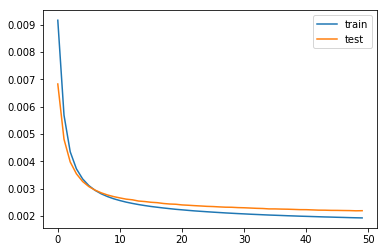

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [33]:
val_proba = model.predict_proba(X_test, batch_size=1024,verbose=1)
test_proba = model.predict_proba(X_go[sp2:], batch_size=1024,verbose=1)

246955/246955 [==============================] - 9s 35us/step


In [34]:
val_proba = pd.DataFrame(val_proba)
test_proba = pd.DataFrame(test_proba)

In [35]:
%%time
val_proba.to_csv('../ensemb2/val_lstm_char_vanila.csv', index = False, header = False)
test_proba.to_csv('../ensemb2/test_lstm_char_vanila.csv', index = False, header = False)

CPU times: user 9min 35s, sys: 14.6 s, total: 9min 49s
Wall time: 9min 58s
